In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from utils_lstm import load_lstm_dfs, load_train_test_lstm
from lstm_data_prep import LstmDataPrep

2024-02-22 22:56:02.492380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_set, test_set = load_train_test_lstm(list_of_dfs=load_lstm_dfs())

In [4]:
print("Train Shape: ",train_set.shape)
print("Test Shape:" ,test_set.shape)

Train Shape:  (13600, 10)
Test Shape: (37401, 10)


New Try

In [11]:
model_pipe = LstmDataPrep(num_splits=34).model_pipeline()

In [12]:
model_pipe

Pipeline(steps=[('transformations',
                 FeatureUnion(transformer_list=[('part_0',
                                                 Pipeline(steps=[('drop_targets',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint',
                                                                                                         'anomaly'])),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('split_sequences',
                                                                  SequenceSplitterTransformer(n_steps=5)),
                                                                 ('classifier',
                                                                  <lstm_model.LstmModel object at 0x14739abf0>)])),
                                                ('part_1',
                                                 Pipeline(steps=[('d...
                                                                  <lstm_model.LstmModel object at 0x149e9b1f0>)])),
                                                ('part_29',
                                                 Pipeline(steps=[('drop_targets',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint',
                                                                                                         'anomaly'])),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('split_sequences',
                                                                  SequenceSplitterTransformer(n_steps=5)),
                                                                 ('classifier',
                                                                  <lstm_model.LstmModel object at 0x149e9b820>)])), ...])),
                ('processing_results', AggregateModelScores())])

In [17]:
res = model_pipe.fit_transform(train_set)

13/13 [==============================] - 0s 3ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 4ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 3ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 3ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 3ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 3ms/step
x (399, 5, 8)
y (399, 8)
13/13 [==============================] - 0s 2ms/step
x (399, 5, 

In [18]:
res = model_pipe.transform(test_set)

1169/1169 [==============================] - 3s 2ms/step


In [29]:
y_pred = res['avg_prediction']

In [31]:
y_pred.value_counts().sort_index()

0.000000    37039
0.029412       57
0.058824      111
0.088235       28
0.117647       12
0.147059        6
0.176471       17
0.205882       63
0.235294       13
0.264706        2
0.294118        3
0.323529       13
0.352941       18
0.382353        7
0.411765        5
0.441176        1
0.470588        1
Name: avg_prediction, dtype: int64

In [20]:
y_test = test_set['anomaly'][5:]

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import numpy as np

In [22]:
def calc_metrics(y_true,y_pred):
    th = 0.35
    accuracy = accuracy_score(y_true, np.where(y_pred>=th,1,0))
    cm = confusion_matrix(y_true, np.where(y_pred>=th,1,0))
    f1 = f1_score(y_true, np.where(y_pred>=th,1,0))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc

def plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Model Evaluation Metrics'):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16, y=1.02)
    confusion_matrix_ax = ax[0]
    roc_curve_ax = ax[1]

    # Confusion Matrix in the first subplot
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=confusion_matrix_ax,cmap='Blues')
    confusion_matrix_ax.set_title('Confusion Matrix')
    confusion_matrix_ax.set_xlabel('Predicted labels')
    confusion_matrix_ax.set_ylabel('True labels')

    # ROC Curve in the second subplot
    roc_curve_ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    roc_curve_ax.legend(loc='lower right')
    # Display the plot
    plt.tight_layout()
    plt.show()

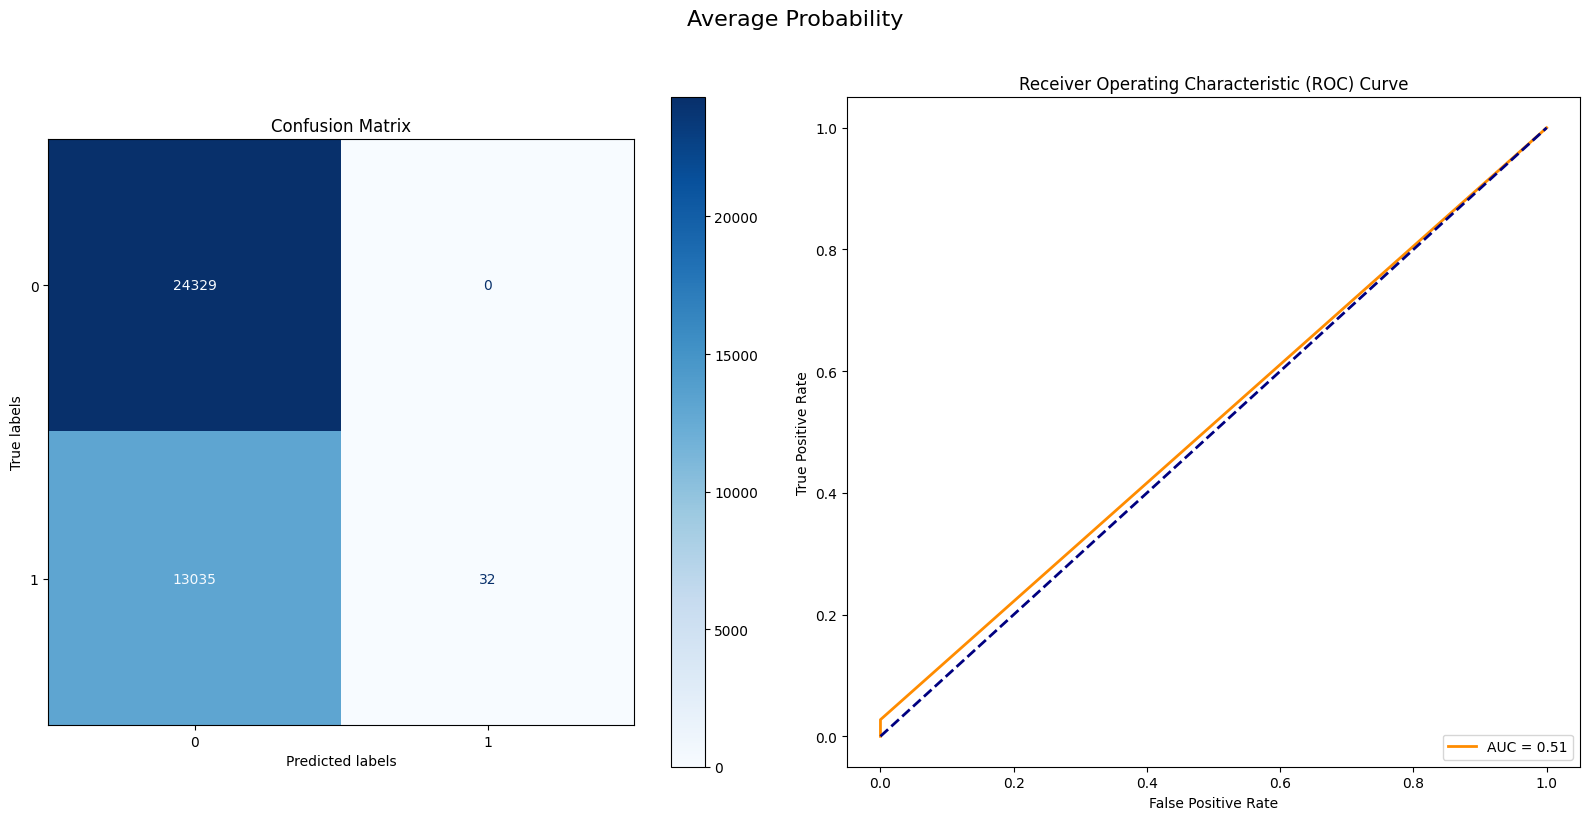

In [23]:
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,y_pred)
plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Average Probability')

In [24]:
accuracy

0.6514333083752273

Old Try

In [ ]:
# preprocess_pipe = LstmDataPrep().get_preprocess_pipeline()
# preprocess_pipe.fit(train_set)
# features_pipe = LstmDataPrep().get_features_pipeline()

In [ ]:
# preprocess_pipe, features_pipe = LstmDataPrep().run()
# # features_pipe


In [ ]:
preprocess_pipe

In [ ]:
features_pipe

In [ ]:
x_train, y_train = preprocess_pipe.fit_transform(train_set)
# x_train, y_train = preprocess_pipe.transform(test_set)

In [ ]:
features_pipe.fit(x_train, y_train)

In [ ]:
x_test, y_test = preprocess_pipe.transform(test_set)

In [ ]:
features_pipe.transform(x_test)


In [ ]:
res = feature_pipe.transform(X_test)
y_pred = res['avg_prediction'].copy()

In [ ]:
# from lstm_model import LstmModel
# model = LstmModel(y_test=y_test,partition_num=1)
# model.fit(x,y)
# res = model.transform(x_test)
